In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# test homography with size(240, 360)

import cv2
batch_size = 10
def loadConfig(filename):
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    return config
test_tf = False
test_corner_def = True

def scale_homography(H, shape, shift=(-1,-1)):
    height, width = shape[0], shape[1]
    trans = np.array([[2./width, 0., shift[0]], [0., 2./height, shift[1]], [0., 0., 1.]])
    H_tf = np.linalg.inv(trans) @ H @ trans
    return H_tf

def sample_homography_batches(config, batch_size=1, shape=np.array([1,1]), tf=False):
    offset = 0
    b = 2

    if tf:
        from utils.homographies import sample_homography as sample_homography
#         shape = np.array([b, b])
        mat_homographies = [sample_homography(shape,
                                          **config['data']['augmentation']['homographic']['params']) for i in range(batch_size)]
        
#         mat_homographies = [scale_homography(sample_homography(shape,
#                                           **config['data']['warped_pair']['params']), shape)
#                                             for i in range(batch_size)]
    else:
        from utils.homographies import sample_homography_np as sample_homography
        mat_homographies = [sample_homography(shape, shift=-1 + offset,
                                          **config['data']['augmentation']['homographic']['params']) for i in range(batch_size)]
    
    mat_homographies = np.stack(mat_homographies, axis=0)
    return mat_homographies



def drawBox(points, img, offset=np.array([0,0]), color=(0,255,0)):
#     print("origin", points)
    offset = offset[::-1]
    points = points + offset    
    points = points.astype(int)
    for i in range(len(points)):
        img = img + cv2.line(np.zeros_like(img),tuple(points[-1+i]), tuple(points[i]), color,5)
    return img

# load config
filename = '../configs/config_test.yaml'
config = loadConfig(filename)

In [4]:
def warp_points_np(points, homographies, device='cpu'):
    """
    Warp a list of points with the given homography.

    Arguments:
        points: list of N points, shape (N, 2).
        homography: batched or not (shapes (B, 3, 3) and (...) respectively).

    Returns: a Tensor of shape (N, 2) or (B, N, 2) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.
    """
    # expand points len to (x, y, 1)
    batch_size = homographies.shape[0]
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    # points = points.to(device)
    # homographies = homographies.(batch_size*3,3)
    # warped_points = homographies*points
    # warped_points = homographies@points.transpose(0,1)
    warped_points = np.tensordot(homographies, points.transpose(), axes=([2], [0]))
    # normalize the points
    warped_points = warped_points.reshape([batch_size, 3, -1])
    warped_points = warped_points.transpose([0, 2, 1])
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]
    return warped_points

### homography visualization for my inplementation

homography visualization for my inplementation
print forward homographies


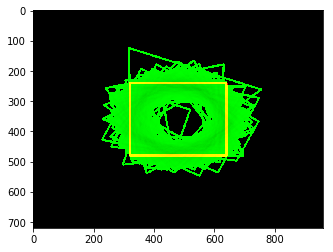

print inverse homographies


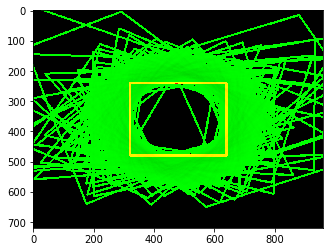

In [5]:
# homography visualization for my inplementation
print("homography visualization for my inplementation")


from numpy.linalg import inv

# sample homography
batch_size = 200
shape = np.array([2,2])
homographies = sample_homography_batches(config, batch_size, shape=shape, tf=False)

# change shapes
height, width = 240, 320
image_shape = np.array([height, width])
homographies = np.stack([scale_homography(H, image_shape, shift=(-1,-1)) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
print("print forward homographies")
plt.imshow(img)
plt.show()

#  inv_homography
inv_homographies = np.stack([inv(H) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, inv_homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    
print("print inverse homographies")
plt.imshow(img)

plt.show()


### homography visualization for tensorflow

homography visualization for tensorflow
print forward homographies


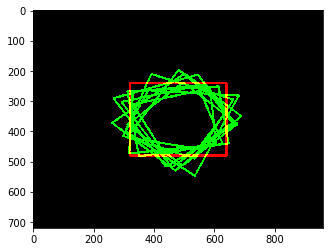

print inverse homographies


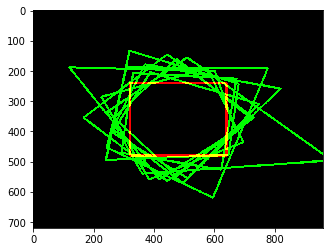

In [6]:
# homography visualization for tensorflow
from numpy.linalg import inv
print("homography visualization for tensorflow")


# sample homography
batch_size = 10

height, width = 240, 320
shape = np.array([height, width])
# homographies = sample_homography_batches(config, batch_size, tf=True)
homographies = sample_homography_batches(config, batch_size, shape=shape, tf=True)
# print(homographies)
# change shapes
# homographies = np.stack([scale_homography(H, image_shape, shift=(0,0)) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
print("print forward homographies")
plt.imshow(img)
plt.show()

#  inv_homography
inv_homographies = np.stack([inv(H) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, inv_homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    
print("print inverse homographies")
plt.imshow(img)

plt.show()


print forward homographies


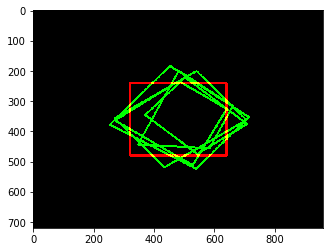

print inverse homographies


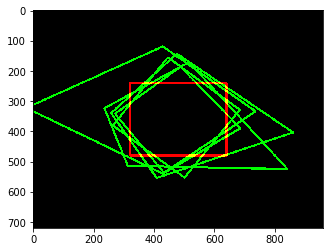

In [7]:
# homography visualization for tensorflow - test with my scaling homography
from numpy.linalg import inv


# sample homography
batch_size = 5

height, width = 240, 320
shape = np.array([height, width])
# homographies = sample_homography_batches(config, batch_size, tf=True)
homographies = sample_homography_batches(config, batch_size, shape=np.array([2,2]), tf=True)
# print(homographies)
# change shapes
homographies = np.stack([scale_homography(H, shape, shift=(0,0)) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
print("print forward homographies")
plt.imshow(img)
plt.show()

#  inv_homography
inv_homographies = np.stack([inv(H) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, inv_homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    
print("print inverse homographies")
plt.imshow(img)

plt.show()


In [8]:
def getHomographyPlot(config, tf=False, batch_size=10):
    height, width = 240, 320
    shape = np.array([height, width])
    if tf:
        homographies = sample_homography_batches(config, batch_size, shape=np.array([2,2]), tf=True)
        homographies = np.stack([scale_homography(H, shape, shift=(0,0)) for H in homographies])
    else:
        shape = np.array([2,2])
        homographies = sample_homography_batches(config, batch_size, shape=shape, tf=False)

        # change shapes
        height, width = 240, 320
        image_shape = np.array([height, width])
        homographies = np.stack([scale_homography(H, image_shape, shift=(-1,-1)) for H in homographies])
        
    # warp points
#     from utils.utils import warp_points_np
    # corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
    corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
    points = warp_points_np(corner_img, homographies)

    # plot shapes
    offset = np.array([height,width])
    img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
    img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
    for i in range(points.shape[0]):
        img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    img_forward = img
#     print("print forward homographies")
#     plt.imshow(img)
#     plt.show()

    #  inv_homography
    inv_homographies = np.stack([inv(H) for H in homographies])

    # warp points
#     from utils.utils import warp_points_np
    # corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
    corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
    points = warp_points_np(corner_img, inv_homographies)

    # plot shapes
    offset = np.array([height,width])
    img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
    img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
    for i in range(points.shape[0]):
        img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    img_inv = img
    return img_forward, img_inv

## Compare my implementation with tensorflow implementation
- you can play with the number
- Left 2 columns are my implementation, right 2 cols are their implementation


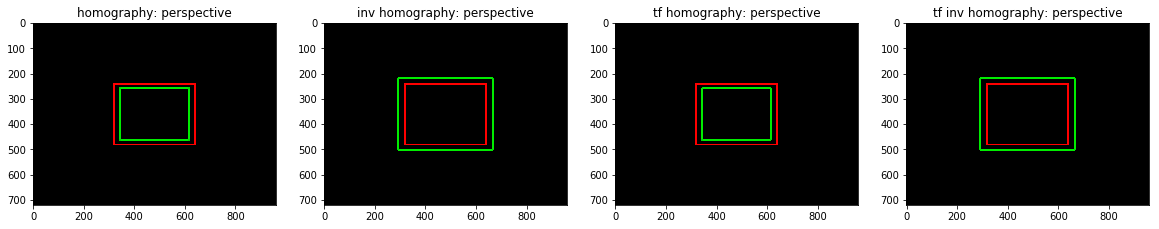

In [9]:

config = {
    'data':{
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': True,
                'params': {
                    'translation': True,
                    'rotation': True,
                    'scaling': True,
                    'perspective': True,
                    'scaling_amplitude': 0.2,
                    'perspective_amplitude_x': 0.2,
                    'perspective_amplitude_y': 0.2,
                    'patch_ratio': 0.85,
                    'max_angle': 1.57,
                    'allow_artifacts': True # true

                },
                'valid_border_margin': 0,
            },
        }
    }
}

config_f = {
    'data':{
        'augmentation': {
            'photometric': {
                'enable': False,
                'primitives': 'all',
                'params': {},
                'random_order': True,
            },
            'homographic': {
                'enable': True,
                'params': {
                    'translation': False,
                    'rotation': False,
                    'scaling': False,
                    'perspective': False,
                    'scaling_amplitude': 0.2,
                    'perspective_amplitude_x': 0.2,
                    'perspective_amplitude_y': 0.2,
                    'patch_ratio': 0.85,
                    'max_angle': 1.57,
                    'allow_artifacts': True # true

                },
                'valid_border_margin': 0,
            },
        }
    }
}

batch_size = 20

rows = 10
cols = 4
scale = 5
count = 1
# test_warping = ['perspective', 'translation', 'rotation', 'scaling']
test_warping = ['perspective']
# test_warping = ['rotation']

for warping in test_warping:
    config_temp = config_f.copy()
#     config_temp['data']['augmentation']['homographic']['params'][warping] = True
    # config_temp['data']['augmentation']['homographic']['params']['rotation'] = True

    # my warping
    img_forward, img_inv = getHomographyPlot(config_temp, batch_size=batch_size)

    plt.figure(figsize=(4*scale, 10*scale))
    plt.subplot(rows,cols,count)
    count += 1
    plt.imshow(img_forward)
    plt.title('homography: ' + warping)
    
    plt.subplot(rows,cols,count)
    count += 1
    plt.imshow(img_inv)
    plt.title('inv homography: ' + warping)

    # tf warping
    img_forward, img_inv = getHomographyPlot(config_temp, tf=True, batch_size=batch_size)

    plt.subplot(rows,cols,count)
    count += 1
    plt.imshow(img_forward)
    plt.title('tf homography: ' + warping)
    
    plt.subplot(rows,cols,count)
    count += 1
    plt.imshow(img_inv)
    plt.title('tf inv homography: ' + warping)
    
plt.show()


[[  0   0]
 [  0 240]
 [320 240]
 [320   0]]


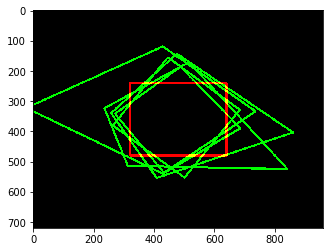

In [10]:
drawBox(corner_img, img, color=(0,255,0), offset=offset)
print(corner_img)
plt.imshow(img)
plt.show()

In [11]:
corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
offset = np.array([1,5])
print(corner_img + offset)

[[  1   5]
 [241   5]
 [241 325]
 [  1 325]]


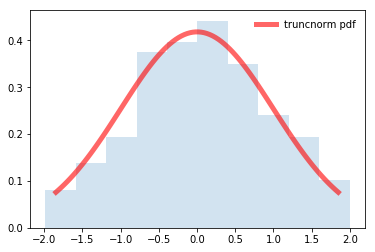

In [12]:
## test truncnorm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a, b = -2, 2
loc=0
scale=1
x = np.linspace(truncnorm.ppf(0.01, a, b),
                truncnorm.ppf(0.99, a, b), 100)
ax.plot(x, truncnorm.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='truncnorm pdf')

r = truncnorm.rvs(a, b, loc=loc, scale=scale, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [13]:
max_angle = 1.57
n_angles = 25
angles = np.linspace(-max_angle, max_angle, num=n_angles)
print("angles: ", angles)

import tensorflow as tf
angles = tf.lin_space(tf.constant(-max_angle), tf.constant(max_angle), n_angles)
print("tf angles: ", angles)


angles:  [-1.57000000e+00 -1.43916667e+00 -1.30833333e+00 -1.17750000e+00
 -1.04666667e+00 -9.15833333e-01 -7.85000000e-01 -6.54166667e-01
 -5.23333333e-01 -3.92500000e-01 -2.61666667e-01 -1.30833333e-01
 -2.22044605e-16  1.30833333e-01  2.61666667e-01  3.92500000e-01
  5.23333333e-01  6.54166667e-01  7.85000000e-01  9.15833333e-01
  1.04666667e+00  1.17750000e+00  1.30833333e+00  1.43916667e+00
  1.57000000e+00]
tf angles:  Tensor("LinSpace_15:0", shape=(25,), dtype=float32)
